## Deep Learning
### Assignment 5
The goal of this assignment is to train a Word2Vec skip-gram model over Text8 data.

In [206]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from IPython.display import display, Image

Download the data from the source website if necessary.

In [78]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [79]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)    # list of words
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

UNK means unknown word, a word that doesn't exist the the vocabulary set


In [80]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))  # list: [('the', 1061396),('of', 593677)....]
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1      # count uknown words
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary    # data - list with number of word in dictionary, 0=uknown

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


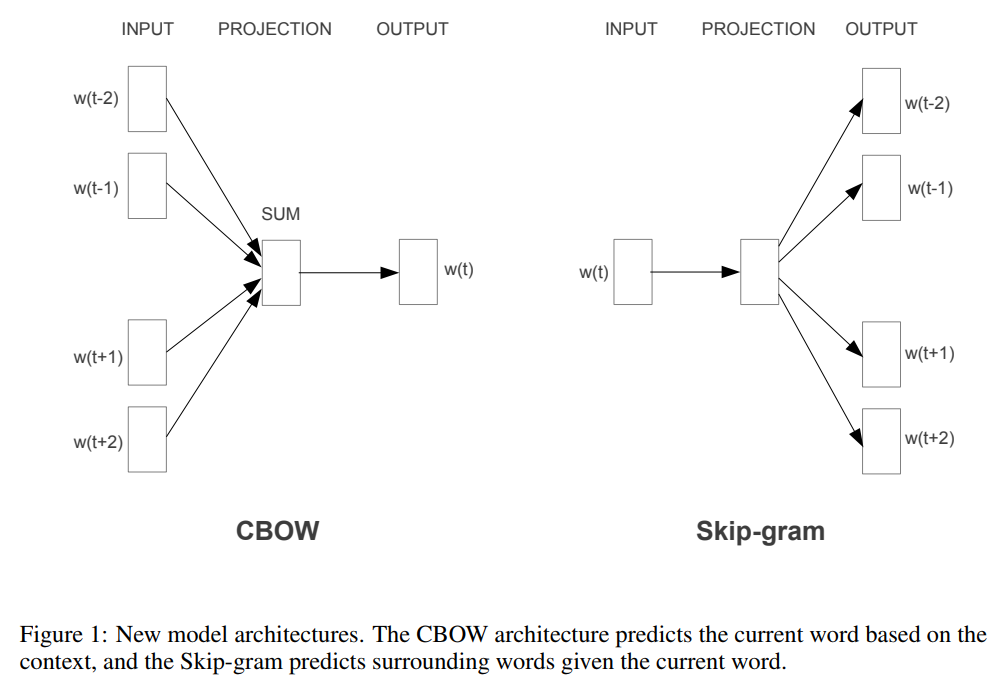

In [208]:
Image('7.PNG')

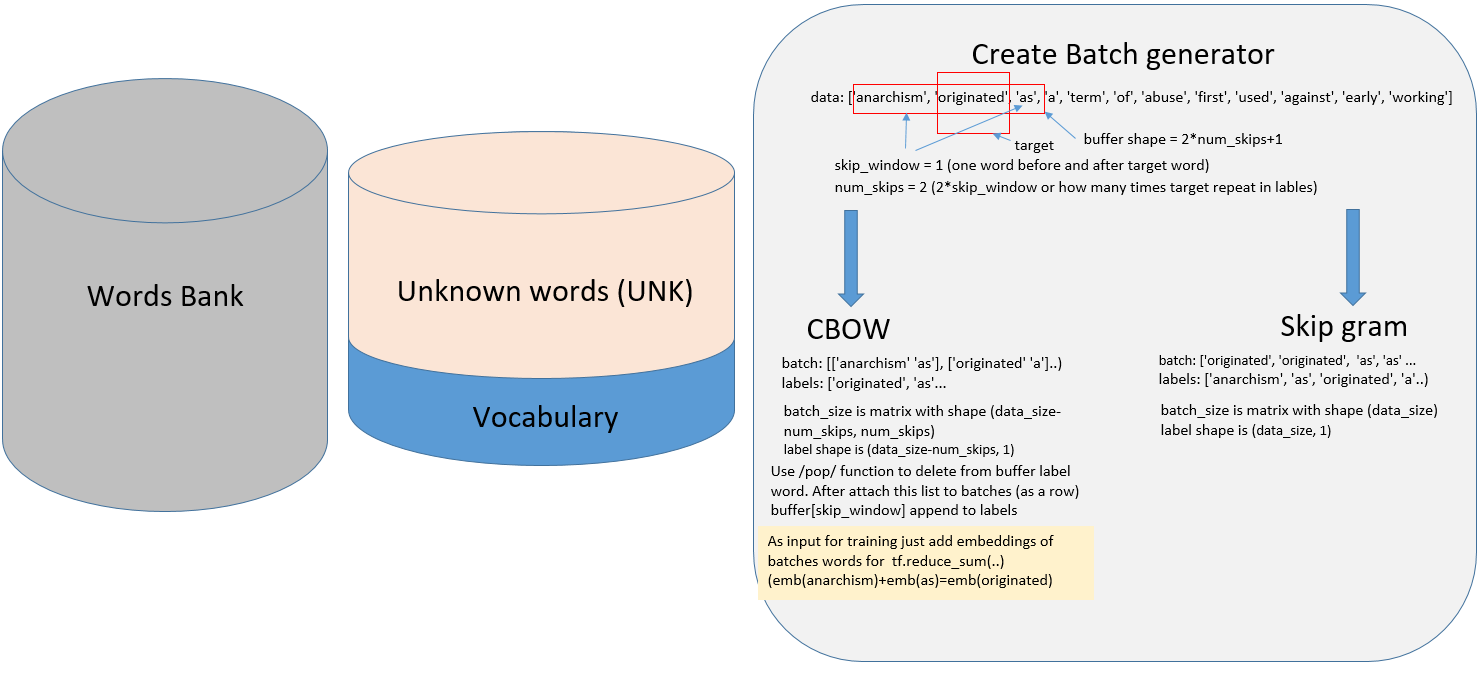

In [207]:
Image('8.PNG')

Function to generate a training batch for the skip-gram model.

In [83]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels  # batch and labels are numbers (indexes in the data)

print('data:', [reverse_dictionary[di] for di in data[:12]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=12, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(12)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a', 'abuse', 'term', 'of', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term']
    labels: ['term', 'anarchism', 'originated', 'a', 'as', 'of', 'term', 'originated', 'of', 'a', 'abuse', 'as']


### How (generate_batch) funciton work
 - Assertions are simply boolean expressions that checks if the conditions return true or not. If it is true, the program does nothing and move to the next line of code. However, if it's false, the program stops and throws an error.
 
 - In the list only (span)-number of elements. Adding new element (span+1) the first is disapear This is like a moving window with length=span. a = deque([3, 4, 5])   a.append(6) = deque([4, 5, 6])

In [84]:
data1 = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
len(data1)

12

In [107]:
# batch_size - number of words in sample
data_index = 0
batch_size = 12
num_skips = 2
skip_window = 1
batch = np.ndarray(shape=(batch_size), dtype=np.int32)      # initialize batch arrray
labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  # initialize label arrray
span = 2 * skip_window + 1 # [ skip_window target skip_window ]
buffer = collections.deque(maxlen=span) 

In [108]:
for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # (data_index + 1) % len(data) - not same as (data_index + 1)
                                               #  % len(data)  - foe case when num_steps > number of batches

In [109]:
for i in range(batch_size//num_skips):
    target = skip_window
    target_to_avoid = [ target ]
    for j in range(num_skips):
        while target in target_to_avoid:
            target = random.randint(0,num_skips)
        batch[i*num_skips+j] = buffer[skip_window]
        labels[i*num_skips+j,0] = buffer[target]
        target_to_avoid.append(target)
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

In [110]:
print([reverse_dictionary[bi] for bi in data[:batch_size]])
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a', 'term', 'abuse', 'of', 'first']


### CBOW batch generation

In [183]:
# batch_size - number of words in sample
data_index = 0
batch_size = 12
num_skips = 4 # skip_window*2
skip_window = 2
batch = np.ndarray(shape=(batch_size-num_skips, num_skips), dtype=np.int32)      # initialize batch arrray
labels = np.ndarray(shape=(batch_size-num_skips, 1), dtype=np.int32)  # initialize label arrray
span = 2 * skip_window + 1 # [ skip_window target skip_window ]
buffer = collections.deque(maxlen=span)

In [184]:
for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # (data_index + 1) % len(data) - not same as (data_index + 1)
                                               #  % len(data)  - foe case when num_steps > number of batches
for i in range(batch_size-num_skips):
    target = skip_window
    target_to_avoid = [ target ]
    z = list(buffer)
    z.pop(skip_window)
    
    batch[i] = z
    labels[i,0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
print([reverse_dictionary[bi] for bi in data[:batch_size]])
print('    batch:', np.asarray([reverse_dictionary[i] for i in batch.reshape((batch_size-num_skips)*num_skips)]).
      reshape(batch_size-num_skips,num_skips))
#print('    batch:', [[reverse_dictionary[i],reverse_dictionary[j]] for i,j in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size-num_skips)])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    batch: [['anarchism' 'originated' 'a' 'term']
 ['originated' 'as' 'term' 'of']
 ['as' 'a' 'of' 'abuse']
 ['a' 'term' 'abuse' 'first']
 ['term' 'of' 'first' 'used']
 ['of' 'abuse' 'used' 'against']
 ['abuse' 'first' 'against' 'early']
 ['first' 'used' 'early' 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [128]:
for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # (data_index + 1) % len(data) - not same as (data_index + 1)
                                               #  % len(data)  - foe case when num_steps > number of batches

In [172]:
a=np.array([[1,2],[3,4]])

In [174]:
for el in a:
    print(a)

[[1 2]
 [3 4]]
[[1 2]
 [3 4]]


In [137]:
batch = np.ndarray(shape=(batch_size-num_skips,num_skips), dtype=np.int32)

In [139]:
batch

array([[1501682920,      32568],
       [  63946256,          0],
       [1851876717, 1750343726],
       [1918902373, 1868789615],
       [1797283958, 1870100837],
       [1931502706, 1768121712],
       [1936025958, 1701344288],
       [ 538976266, 1869439264],
       [1915578222, 1663072111],
       [1918959727, 1668178281]], dtype=int32)

In [140]:
batch[1]=[12,12]

In [142]:
batch[1]

array([12, 12], dtype=int32)

###  For loss used tf.nn.sampled_softmax_loss 
https://stackoverflow.com/questions/35241251/in-tensorflow-what-is-the-difference-between-sampled-softmax-loss-and-softmax-c
If your target vocabulary(or in other words amount of classes you want to predict) is really big, it is very hard to use regular softmax, because you have to calculate probability for every word in dictionary. By Using  sampled_softmax_loss you only take in account subset V of your vocabulary to calculate your loss.

In [20]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [21]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.881597
Nearest to also: overly, advocated, kri, reunified, exactly, baumgarten, addition, wesley,
Nearest to seven: hebron, clarity, arcades, gilmore, brontosaurus, vicente, ideal, kgf,
Nearest to is: knitted, pontius, papadopoulos, obiang, taper, flavianum, liberty, simcoe,
Nearest to who: alleged, predicate, anesthesia, indecent, kvac, roam, rescuers, investigated,
Nearest to time: gut, turning, accolades, sign, earp, salman, tractable, eml,
Nearest to been: mirabilis, logs, moves, bind, horror, paleontologists, overrides, pune,
Nearest to over: austerlitz, edible, virtualization, byu, kusakabe, christianization, collection, unguarded,
Nearest to i: predestination, privilege, dedicates, juries, routines, deformations, arming, do,
Nearest to he: childs, worshipper, stagnated, suiko, mousa, baralong, repair, ade,
Nearest to be: lemon, evangelist, monarchists, sys, mantled, prost, alu, catholicism,
Nearest to the: linger, revue, fundy, restorer, uru

Average loss at step 56000: 3.440861
Average loss at step 58000: 3.395121
Average loss at step 60000: 3.394706
Nearest to also: now, often, never, still, traditionally, commonly, sometimes, usually,
Nearest to seven: eight, four, six, nine, five, three, zero, one,
Nearest to is: was, contains, are, has, be, includes, became, pseudocode,
Nearest to who: which, he, she, still, actually, they, that, also,
Nearest to time: trials, exception, way, year, dolphin, exogenous, interaction, kinds,
Nearest to been: become, be, already, bind, had, received, were, was,
Nearest to over: through, between, within, sorties, filamentous, saxon, principal, out,
Nearest to i: ii, we, you, t, they, g, assembl, wacky,
Nearest to he: she, it, they, there, who, soon, later, we,
Nearest to be: been, refer, become, was, is, have, shouting, win,
Nearest to the: its, their, a, this, his, each, some, our,
Nearest to use: most, possession, form, basis, hoop, position, order, newsweek,
Nearest to to: must, moluccas,

In [26]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

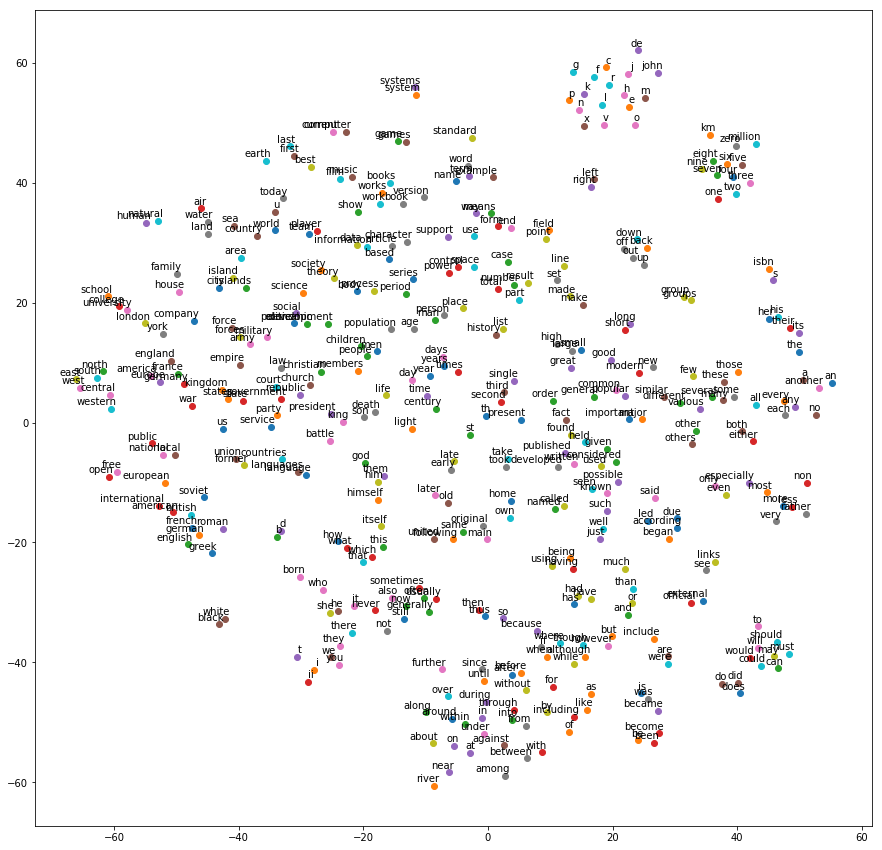

In [27]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Problem

An alternative to skip-gram is another Word2Vec model called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.


In [201]:
# num_skips = 2
# skip_window = 1
#batch = np.ndarray(shape=(batch_size - num_skips,num_skips), dtype=np.int32)      # initialize batch arrray
#labels = np.ndarray(shape=(batch_size-num_skips, 1), dtype=np.int32)  # initialize label arrray
# span = 2 * skip_window + 1 # [ skip_window target skip_window ]
# buffer = collections.deque(maxlen=span)
data_index = 0
batch_size = 12
def generate_batch_cbow(batch_size, num_skips, skip_window):
    global data_index
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    batch = np.ndarray(shape=(batch_size - num_skips,num_skips), dtype=np.int32)      # initialize batch arrray
    labels = np.ndarray(shape=(batch_size-num_skips, 1), dtype=np.int32)  # initialize label arrray
    for _ in range(span):  # fill initial buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)  # (data_index + 1) % len(data) - not same as (data_index + 1)
                                               #  % len(data)  - foe case when num_steps > number of batches
    for i in range(batch_size-num_skips):
        z = list(buffer)
        z.pop(skip_window)
        batch[i] = z
        labels[i,0] = buffer[skip_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels  # batch and labels are numbers (indexes in the data)

print('data:', [reverse_dictionary[di] for di in data[:batch_size]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print([reverse_dictionary[bi] for bi in data[:batch_size]])
    print('    batch:', np.asarray([reverse_dictionary[i] for i in batch.reshape((batch_size-num_skips)*num_skips)]).
      reshape(batch_size-num_skips,num_skips))
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size-num_skips)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    batch: [['anarchism' 'as']
 ['originated' 'a']
 ['as' 'term']
 ['a' 'of']
 ['term' 'abuse']
 ['of' 'first']
 ['abuse' 'used']
 ['first' 'against']
 ['used' 'early']
 ['against' 'working']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    batch: [['anarchism' 'originated' 'a' 'term']
 ['originated' 'as' 'term' 'of']
 ['as' 'a' 'of' 'abuse']
 ['a' 'term' 'abuse' 'first']
 ['term' 'of' 'first' 'used']
 ['of' 'abuse' 'used' 'against']
 ['abuse' 'first' 'against' 'early']
 ['first' 'used' 'early' 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [198]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size - num_skips,num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size - num_skips, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed,1), # axis=0 rows
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))    # axis=1 columns

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [199]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.179891
Nearest to zero: televangelist, modernist, aur, marilyn, tsang, reciting, attendance, preprocessor,
Nearest to about: choctaws, kwashiorkor, repeatable, unleavened, restatement, deny, destiny, isao,
Nearest to i: districts, birthrate, ajaccio, birthday, gives, verrocchio, uncovering, crunch,
Nearest to his: macross, zack, galatians, antagonists, byelorussia, panic, summoned, enslavement,
Nearest to up: elkins, camcorder, anger, jaya, prover, lighthearted, dollfuss, colchis,
Nearest to new: randle, fdp, meher, grievances, incremented, reclusive, rehab, mahavira,
Nearest to five: lemming, megalithic, popolo, panamanian, orinoco, analysed, progressions, theobald,
Nearest to which: window, neighborhood, monody, resistors, shrinking, hala, dense, pac,
Nearest to years: pomeroy, violently, roadside, shrubs, simulcast, encroachment, officials, cataclysm,
Nearest to not: saskatchewan, slurred, compilers, berengar, banisteriopsis, taper, closed, wolf

Average loss at step 52000: 2.844035
Average loss at step 54000: 2.859127
Average loss at step 56000: 2.863564
Average loss at step 58000: 2.739580
Average loss at step 60000: 2.830037
Nearest to zero: five, seven, six, four, eight, nine, three, two,
Nearest to about: around, bracelets, dflp, regarding, cools, alternately, deny, speer,
Nearest to i: we, you, they, g, ii, wied, incessantly, equals,
Nearest to his: her, their, my, your, our, its, the, whose,
Nearest to up: out, down, off, them, him, back, together, talib,
Nearest to new: old, different, seminary, deco, isolation, ilyich, reclusive, paraguayan,
Nearest to five: seven, six, four, eight, nine, zero, three, two,
Nearest to which: that, this, what, also, usually, who, where, alphorn,
Nearest to years: days, months, centuries, hours, decades, times, weeks, year,
Nearest to not: never, still, actually, now, almost, always, usually, necessarily,
Nearest to this: which, it, the, what, agis, any, another, some,
Nearest to would: c

In [203]:
num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

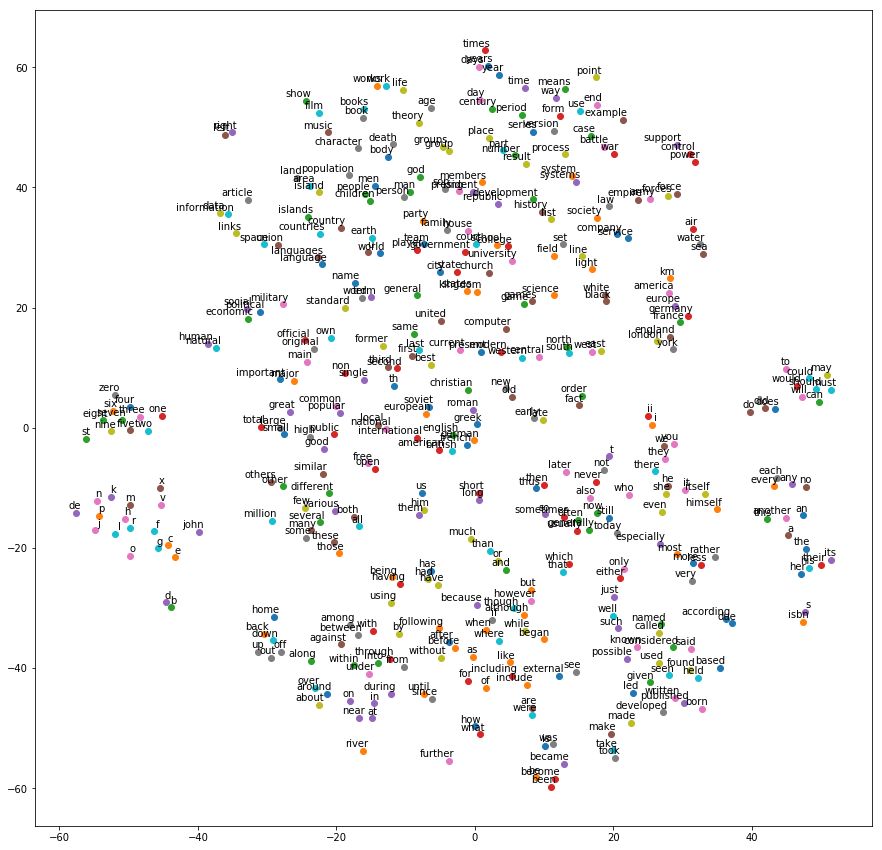

In [205]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)